In [55]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import os
import importlib
import logging
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [56]:
training_data = np.load("../../Data/n1000000_0910_all_flat.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta
target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                         training_data["delta"]/180*np.pi])

split = 900000
x_train = data_all[:split]
y_train = target[:split]
x_train_poisson = np.random.poisson(x_train)/1000

x_val = data_all[split:]
y_val = target[split:]
x_val_poisson = np.random.poisson(x_val)/1000

In [57]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [58]:
hidden_units = [16, 16]
learning_rate = 0.001

In [59]:
def create_bnn_model(train_size):
    inputs = tf.keras.Input(shape=(len(x_train[0]),), name = 'input')
    features = tf.keras.layers.Dense(64, activation='relu')(inputs)
    features = tf.keras.layers.Dense(16, activation='relu')(features)
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = tf.keras.layers.Dense(units=3)(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [60]:
bnn = create_bnn_model(split)
bnn.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)
bnn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 144)]             0         
                                                                 
 dense_15 (Dense)            (None, 32)                4640      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_variational_10 (Dense  (None, 8)                2700      
 Variational)                                                    
                                                                 
 dense_variational_11 (Dense  (None, 8)                2700      
 Variational)                                                    
                                                                 
 dense_17 (Dense)            (None, 3)                 27  

In [70]:
bnn.fit(x_train/1000, y_train,
            validation_data=(x_val/1000, y_val),
            batch_size=64,
            epochs=20,
            verbose=1,
            shuffle = True
            )

Epoch 1/10
14063/14063 [==============================] - 79s 6ms/step - loss: 0.1150 - root_mean_squared_error: 0.3376 - val_loss: 0.1938 - val_root_mean_squared_error: 0.4390
Epoch 2/10
14063/14063 [==============================] - 79s 6ms/step - loss: 0.1119 - root_mean_squared_error: 0.3329 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2796
Epoch 3/10
14063/14063 [==============================] - 78s 6ms/step - loss: 0.1090 - root_mean_squared_error: 0.3284 - val_loss: 0.0963 - val_root_mean_squared_error: 0.3085
Epoch 4/10
14063/14063 [==============================] - 78s 6ms/step - loss: 0.1083 - root_mean_squared_error: 0.3275 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2454
Epoch 5/10
14063/14063 [==============================] - 79s 6ms/step - loss: 0.1076 - root_mean_squared_error: 0.3264 - val_loss: 0.1281 - val_root_mean_squared_error: 0.3564
Epoch 6/10
14063/14063 [==============================] - 79s 6ms/step - loss: 0.1041 - root_mean_squared_error: 0.

In [71]:
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
result = []
for _ in tqdm(range(10000)):
    result.append(bnn.predict(np.array([data_all[0]]))[0])
result = np.array(result)

100%|██████████| 10000/10000 [09:43<00:00, 17.13it/s]


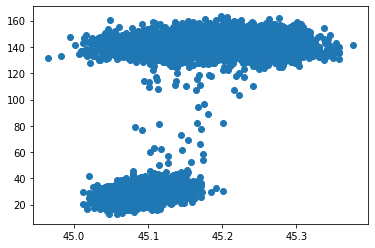

In [72]:
import matplotlib.pyplot as plt
plt.scatter(result[:, 1]*180/np.pi, result[:, 2]*180/np.pi)

In [73]:
np.savez('./contours/bnn.npz', result)

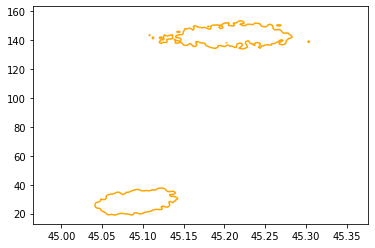

In [75]:
import corner
corner.hist2d(result[:, 1]*180/np.pi, result[:, 2]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='orange',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
